In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

import torch
from model import LocCLIPLightning, GlobalPositionEncDec

from sklearn.cluster import AgglomerativeClustering, KMeans
# from sklearn.metrics.pairwise import cosine_similarity
import gensim
from gensim.corpora import Dictionary
from gensim.models import TfidfModel

In [2]:
# Set seed
np.random.seed(0)

# Load data

## Urban space

In [3]:
caz = gpd.read_file('data/gis/CAZ/lp-consultation-oct-2009-central-activities-zone.shp')
caz

,Boundary,Area_Ha,Updated,Source,Comments,Shape_Leng,Shape_Area,geometry
0,Central Activities Zone,3352.2,FALP - Sept 06,London Plan Consultation Draft,Illustrative use only,47523.258353,3.352231e+07,"POLYGON ((533372.218 179366.595, 533371.815 17..."


In [4]:
inner_london = gpd.read_file("data/gis/inner_london/lp-consultation-oct-2009-inner-outer-london.shp")
inner_london

,Boundary,Source,Area_Ha,Shape_Leng,Shape_Area,geometry
0,Inner London,London Plan Consultation Draft,34863.295694,117020.737488,3.486330e+08,"POLYGON ((522055.597 178014.703, 521975.801 17..."


<Axes: >

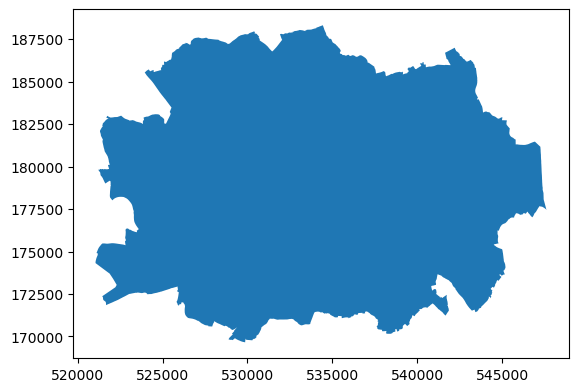

In [5]:
inner_london.plot()

In [6]:
london_hex = gpd.read_file('data/gis/london_hex/Hex350_grid_GLA.shp')

In [8]:
hex_cluster_res = london_hex.copy()
hex_cluster_res

,Col_ID,Row_ID,Hex_ID,Centroid_X,Centroid_Y,area,geometry
0,1063,1211,10631211,503871.30860,175625.7975,106088.115,"POLYGON ((503669.236 175625.797, 503770.272 17..."
1,1064,1210,10641210,504174.41745,175450.7975,106088.080,"POLYGON ((503972.345 175450.797, 504073.381 17..."
2,1064,1212,10641212,504174.41745,175800.7975,106088.080,"POLYGON ((503972.345 175800.797, 504073.381 17..."
3,1064,1214,10641214,504174.41745,176150.7975,106088.080,"POLYGON ((503972.345 176150.797, 504073.381 17..."
4,1064,1216,10641216,504174.41745,176500.7975,106088.080,"POLYGON ((503972.345 176500.797, 504073.381 17..."
...,...,...,...,...,...,...,...
15036,1253,1265,12531265,561461.99790,185075.7975,106088.115,"POLYGON ((561259.925 185075.797, 561360.962 18..."
15037,1253,1267,12531267,561461.99790,185425.7975,106088.115,"POLYGON ((561259.925 185425.797, 561360.962 18..."
15038,1253,1269,12531269,561461.99790,185775.7975,106088.115,"POLYGON ((561259.925 185775.797, 561360.962 18..."
15039,1253,1271,12531271,561461.99790,186125.7975,106088.115,"POLYGON ((561259.925 186125.797, 561360.962 18..."


## POIs

In [9]:
# Get the pre-determined class_idx
df_class_idx = pd.read_csv("baselines/poiclass_idx.csv")
df_class_idx

,classname,class_idx
0,Abrasive Products and Grinding Equipment,0
1,Access Equipment,1
2,Accident and Emergency Hospitals,2
3,Accountants and Auditors,3
4,Adhesives and Sealants,4
...,...,...
573,Workwear,573
574,X-Ray Services,574
575,Youth Accommodation,575
576,Youth Organisations,576


In [ ]:
# london_poi = gpd.read_file("data/london_poi_202203/london_poi.geojson")
# london_poi

,ref_no,name,feature_easting,feature_northing,pointx_class,groupname,categoryname,classname,admin_boundary,postcode,geometry
0,18369840,Kingdom Hall of Jehovah's Witnesses,520383.0,179736.0,06340459,Public Infrastructure,Infrastructure and Facilities,Places Of Worship,Ealing London Boro,W3,POINT (520383.000 179736.000)
1,18369845,Kingdom Hall of Jehovah's Witnesses,523459.0,179519.0,06340459,Public Infrastructure,Infrastructure and Facilities,Places Of Worship,Hammersmith and Fulham London Boro,W6,POINT (523459.000 179519.000)
2,18369858,Kingdom Hall of Jehovah's Witnesses,525131.0,173764.0,06340459,Public Infrastructure,Infrastructure and Facilities,Places Of Worship,Wandsworth London Boro,SW18,POINT (525131.000 173764.000)
3,18369880,Kingdom Hall of Jehovah's Witnesses,529914.0,171540.0,06340459,Public Infrastructure,Infrastructure and Facilities,Places Of Worship,Lambeth London Boro,SW16,POINT (529914.000 171540.000)
4,18370729,Kingdom Hall of Jehovah's Witnesses,528169.0,187994.0,06340459,Public Infrastructure,Infrastructure and Facilities,Places Of Worship,Haringey London Boro,N6,POINT (528169.000 187994.000)
...,...,...,...,...,...,...,...,...,...,...,...
339951,145881512,Abbey Community Centre,543777.0,184393.0,06340456,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,Barking and Dagenham London Boro,IG11 8LQ,POINT (543777.000 184393.000)
339952,145881660,Scouts,508075.0,186144.0,06350452,Public Infrastructure,Organisations,Youth Organisations,Hillingdon London Boro,UB10 8RE,POINT (508075.000 186144.000)
339953,145881923,St Albans Church Hall,513225.9,188388.8,06340456,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,Harrow London Boro,HA2 7PF,POINT (513225.900 188388.800)
339954,145881928,Brickfield Community Centre,517119.2,177291.2,06340456,Public Infrastructure,Infrastructure and Facilities,Halls and Community Centres,Hounslow London Boro,TW8 8JN,POINT (517119.200 177291.200)


# CaLLiPer

## Helper function

In [23]:
def load_model(ckpt_path, device, return_all=False):
    ckpt = torch.load(ckpt_path, map_location=device)
    lightning_model = LocCLIPLightning(**ckpt["hyper_parameters"]).to(device)
    lightning_model.load_state_dict(ckpt["state_dict"])
    lightning_model.eval()

    model = lightning_model.model

    if return_all:
        return model
    else:
        return model.loc_enc


def get_embedding(coordinates, model):
    """
    coordinates: torch.Tensor of shape (N, 2)
    return: torch.Tensor of shape (N, embedding_dim)
    """
    device = next(model.parameters()).device
    coordinates = coordinates.double().to(device)
    with torch.no_grad():
        return model(coordinates)


def clustering(embeddings, n_clusters, cluster_method='agg', normalise="unit"):
    """
    Cluster the embeddings using Aggomarative clustering based on cosine similarity
    return: np.array of shape (N,) where N is the number of embeddings
    """
    # cos_sim = cosine_similarity(embeddings, embeddings)
    # Normalise the embeddings - L2 norm
    if normalise == "unit":
        embeddings = embeddings / np.linalg.norm(embeddings, axis=1)[:, None]
    elif normalise == "zscore":
        embeddings = (embeddings - embeddings.mean(axis=0)) / (embeddings.std(axis=0) + 1e-8)
    elif normalise == "minmax":
        embeddings = (embeddings - embeddings.min(axis=0)) / ((embeddings.max(axis=0) - embeddings.min(axis=0)) + 1e-8)
    elif normalise == "none":
        pass
    else:
        raise ValueError("Normalisation method not recognised")

    if cluster_method == 'agg':
        clustering = AgglomerativeClustering(n_clusters=n_clusters, metric='cosine', linkage='average')
    elif cluster_method == 'kmeans':
        clustering = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = clustering.fit_predict(embeddings)
    return clusters

## Hex centroid

In [11]:
ckpt_path = "checkpoints/epoch=63-val_loss=6.42.ckpt"
location_encoder = load_model(ckpt_path, "cuda:0")

# Get the embeddings of the centroids
hex_centroid_embeddings = get_embedding(torch.tensor(london_hex[['Centroid_X', 'Centroid_Y']].values), location_encoder)
hex_centroid_embeddings = hex_centroid_embeddings.cpu().numpy()

Text(0.5, 1.0, 'Elbow Method')

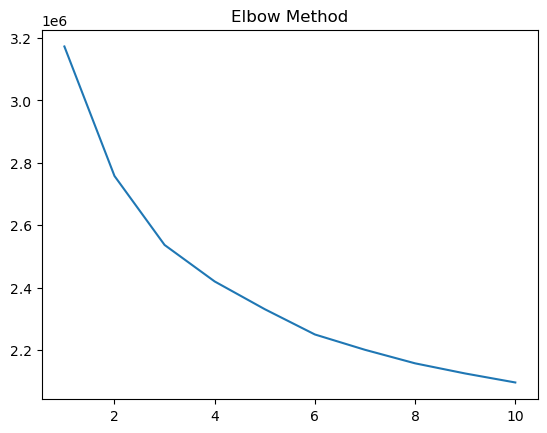

In [24]:
# Use Elbow method to do a bit of investigation of the number of clusters
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(hex_centroid_embeddings)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')

Text(0.5, 1.0, 'Silhouette Score')

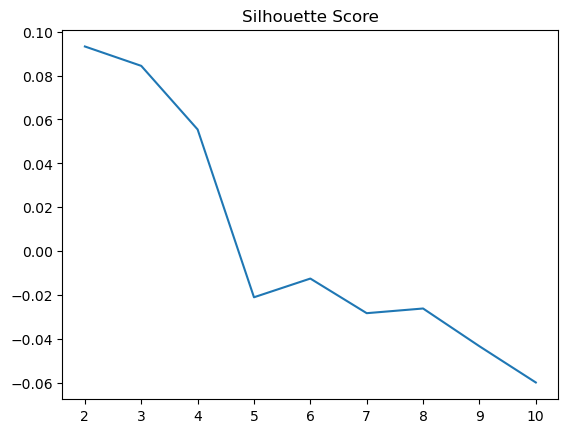

In [25]:
# The corresponding Silhouette score under different K(s)
from sklearn.metrics import silhouette_score

sil = []
for i in range(2, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(hex_centroid_embeddings)
    labels = kmeans.labels_
    sil.append(silhouette_score(hex_centroid_embeddings, labels, metric='cosine'))

plt.plot(range(2, 11), sil)
plt.title('Silhouette Score')

In [26]:
# Cluster the embeddings
n_clusters = 4
clusters = clustering(hex_centroid_embeddings, n_clusters, cluster_method='kmeans', normalise="unit")
clusters += 1
print(clusters.shape)

(15041,)


In [27]:
values, counts = np.unique(clusters, return_counts=True)
# make it a pd.DataFrame
sample_counts = pd.DataFrame({'cluster': values, 'count': counts})
sample_counts

,cluster,count
0,1,1611
1,2,6671
2,3,3390
3,4,3369


In [28]:
hex_cluster_res['clst_calliper'] = clusters
hex_cluster_res

,Col_ID,Row_ID,Hex_ID,Centroid_X,Centroid_Y,area,geometry,clst_calliper
0,1063,1211,10631211,503871.30860,175625.7975,106088.115,"POLYGON ((503669.236 175625.797, 503770.272 17...",1
1,1064,1210,10641210,504174.41745,175450.7975,106088.080,"POLYGON ((503972.345 175450.797, 504073.381 17...",1
2,1064,1212,10641212,504174.41745,175800.7975,106088.080,"POLYGON ((503972.345 175800.797, 504073.381 17...",3
3,1064,1214,10641214,504174.41745,176150.7975,106088.080,"POLYGON ((503972.345 176150.797, 504073.381 17...",3
4,1064,1216,10641216,504174.41745,176500.7975,106088.080,"POLYGON ((503972.345 176500.797, 504073.381 17...",1
...,...,...,...,...,...,...,...,...
15036,1253,1265,12531265,561461.99790,185075.7975,106088.115,"POLYGON ((561259.925 185075.797, 561360.962 18...",3
15037,1253,1267,12531267,561461.99790,185425.7975,106088.115,"POLYGON ((561259.925 185425.797, 561360.962 18...",3
15038,1253,1269,12531269,561461.99790,185775.7975,106088.115,"POLYGON ((561259.925 185775.797, 561360.962 18...",3
15039,1253,1271,12531271,561461.99790,186125.7975,106088.115,"POLYGON ((561259.925 186125.797, 561360.962 18...",3


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


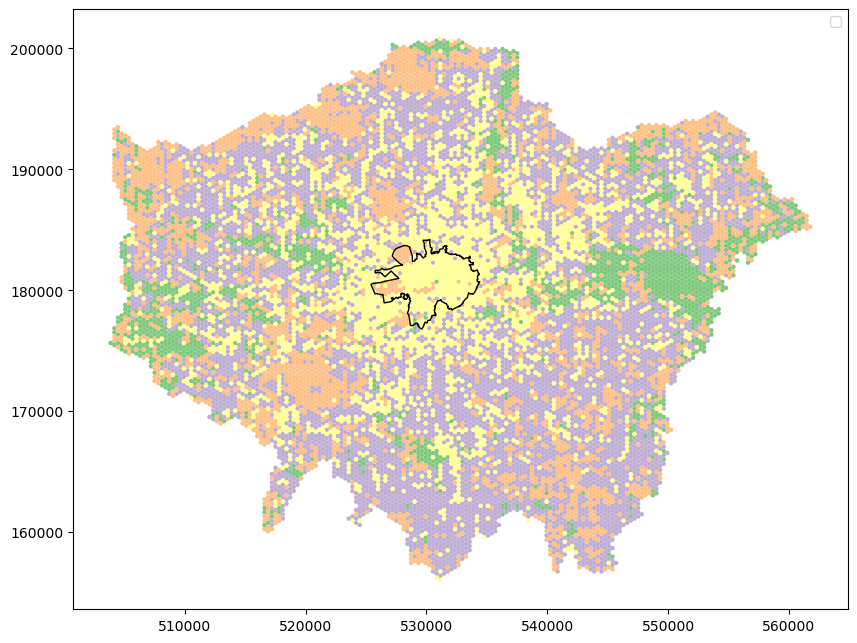

In [30]:
# Results - spherical harmonics
# Create a color map from 'tab10'
cmap = plt.get_cmap('Accent')

# Assuming the 'cluster' column holds the cluster labels
cluster_labels = list(range(1, 5))

# Create a dictionary to map each cluster label to a color from 'tab10'
color_mapping = {label: cmap(i) for i, label in enumerate(cluster_labels)}

# Plot the GeoDataFrame, setting the color for each cluster
fig, ax = plt.subplots(figsize=(10, 10))
for label, color in color_mapping.items():
    hex_cluster_res[hex_cluster_res['clst_calliper'] == label].plot(ax=ax, color=color)

# Plot CAZ, no fill color
caz.plot(ax=ax, edgecolor='black', facecolor='none')

# Add legend
plt.legend()

# Show plot
plt.show()

In [31]:
# green 1  Green space
# purple 2  Infrastructure and industrial areas
# orange 3  Residential areas
# yellow 4  City centre and commercial areas

# Manually adjust the cluster labels
# 1->2, 2->3, 3->1
hex_cluster_res.loc[hex_cluster_res['clst_calliper'] == 2, 'clst_calliper'] = -1
hex_cluster_res.loc[hex_cluster_res['clst_calliper'] == 1, 'clst_calliper'] = 2
hex_cluster_res.loc[hex_cluster_res['clst_calliper'] == 3, 'clst_calliper'] = 1
hex_cluster_res.loc[hex_cluster_res['clst_calliper'] == -1, 'clst_calliper'] = 3

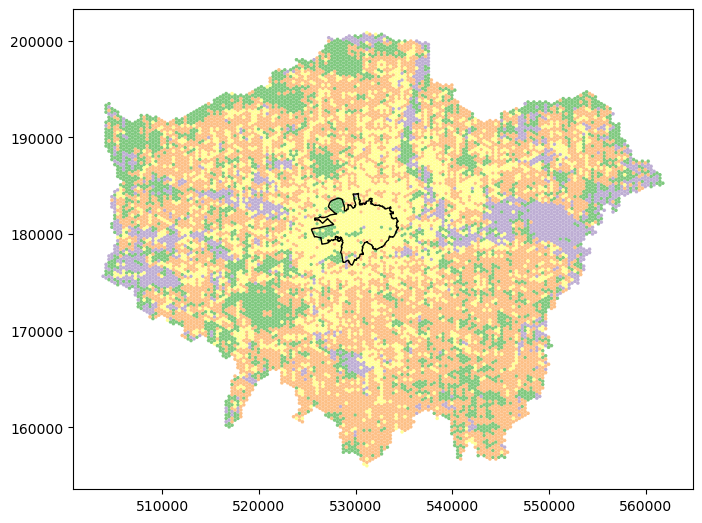

In [32]:
# Create a color map from 'tab10'
cmap = plt.get_cmap('Accent')

# Assuming the 'cluster' column holds the cluster labels
cluster_labels = list(range(1, 5))

# Create a dictionary to map each cluster label to a color from 'tab10'
color_mapping = {label: cmap(i) for i, label in enumerate(cluster_labels)}

# Plot the GeoDataFrame, setting the color for each cluster
fig, ax = plt.subplots(figsize=(8, 8))
for label, color in color_mapping.items():
    hex_cluster_res[hex_cluster_res['clst_calliper'] == label].plot(ax=ax, color=color)

# Plot CAZ, no fill color
caz.plot(ax=ax, edgecolor='black', facecolor='none')

# Show plot
plt.show()

In [ ]:
# CLUSTERING PURITY SCORE
# Cannot do it because there's no ground truth

# Space2Vec

In [33]:
## Load space2vec model
# Load the pretrained location encoder
device = "cuda:1"
# Hyperparameters
location_encoder_hparams = {
    "pe_type": "grid",
    "nn_type": "fcnet",
    "min_lambda": 100,
    "max_lambda": 10000,
    "frequency_num": 32,
    "dim_hidden": 256,
    "dim_output": 128
    }

feature_embed_dim = 64
num_neg_samples = 10
num_poi_classes = 578

ckpt_path = "baselines/pretrained/space2vec_global_pos_best_1024.pth"
ckpt = torch.load(ckpt_path, map_location=device)

space2vec_model = GlobalPositionEncDec(num_poi_classes, feature_embed_dim, location_encoder_hparams, num_neg_samples).to(device)
space2vec_model.load_state_dict(ckpt)

pretrianed_loc_encoder = space2vec_model.loc_encoder

# pretrianed_loc_encoder = load_loc_encoder(ckpt_path, device=device)
for param in pretrianed_loc_encoder.parameters():
    param.requires_grad = False

# Get the embeddings of the centroids
hex_centroid_embeddings = get_embedding(torch.tensor(london_hex[['Centroid_X', 'Centroid_Y']].values), pretrianed_loc_encoder)
hex_centroid_embeddings = hex_centroid_embeddings.cpu().numpy()

In [36]:
# Cluster the embeddings
n_clusters = 4
clusters = clustering(hex_centroid_embeddings, n_clusters, cluster_method='kmeans', normalise="unit")
clusters += 1
print(clusters.shape)
values, counts = np.unique(clusters, return_counts=True)
# make it a pd.DataFrame
sample_counts = pd.DataFrame({'cluster': values, 'count': counts})
sample_counts

(15041,)


,cluster,count
0,1,3870
1,2,2475
2,3,4481
3,4,4215


In [41]:
hex_cluster_res['clst_space2vec'] = clusters

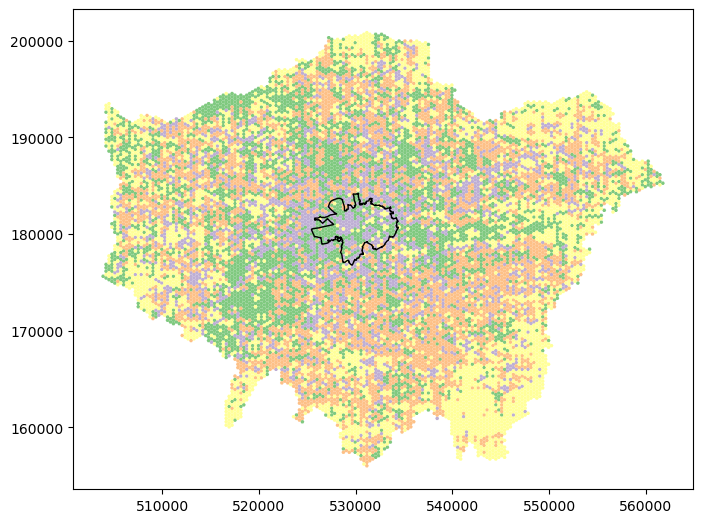

In [43]:
# Create a color map from 'tab10'
cmap = plt.get_cmap('Accent')

# Assuming the 'cluster' column holds the cluster labels
cluster_labels = list(range(1, 5))

# Create a dictionary to map each cluster label to a color from 'tab10'
color_mapping = {label: cmap(i) for i, label in enumerate(cluster_labels)}

# Plot the GeoDataFrame, setting the color for each cluster
fig, ax = plt.subplots(figsize=(8, 8))
for label, color in color_mapping.items():
    hex_cluster_res[hex_cluster_res['clst_space2vec'] == label].plot(ax=ax, color=color)

# Plot CAZ, no fill color
caz.plot(ax=ax, edgecolor='black', facecolor='none')
# Show plot
plt.show()

In [44]:
# green 1  Green space
# purple 2  Infrastructure and industrial areas
# orange 3  Residential areas
# yellow 4  City centre and commercial areas

# Manually adjust the cluster labels
# 2->4, 3->2, 4->3
hex_cluster_res.loc[hex_cluster_res['clst_space2vec'] == 4, 'clst_space2vec'] = -1
hex_cluster_res.loc[hex_cluster_res['clst_space2vec'] == 2, 'clst_space2vec'] = 4
hex_cluster_res.loc[hex_cluster_res['clst_space2vec'] == 3, 'clst_space2vec'] = 2
hex_cluster_res.loc[hex_cluster_res['clst_space2vec'] == -1, 'clst_space2vec'] = 3

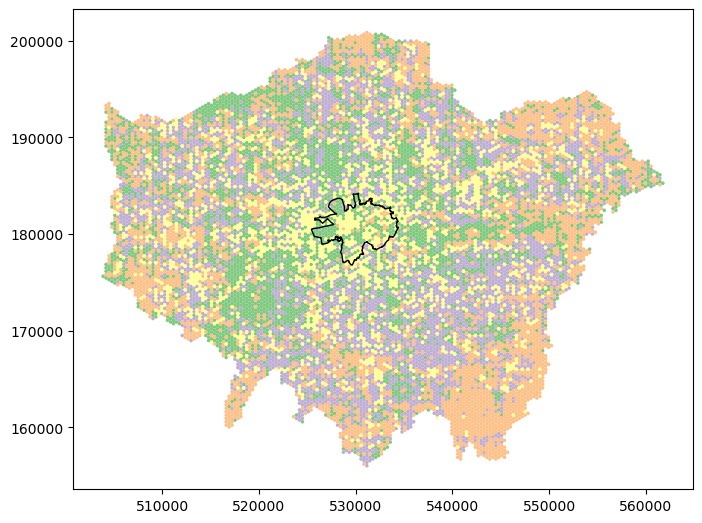

In [45]:
# Create a color map from 'tab10'
cmap = plt.get_cmap('Accent')

# Assuming the 'cluster' column holds the cluster labels
cluster_labels = list(range(1, 5))

# Create a dictionary to map each cluster label to a color from 'tab10'
color_mapping = {label: cmap(i) for i, label in enumerate(cluster_labels)}

# Plot the GeoDataFrame, setting the color for each cluster
fig, ax = plt.subplots(figsize=(8, 8))
for label, color in color_mapping.items():
    hex_cluster_res[hex_cluster_res['clst_space2vec'] == label].plot(ax=ax, color=color)

# Plot CAZ, no fill color
caz.plot(ax=ax, edgecolor='black', facecolor='none')

# Show plot
plt.show()

# Other baselines

Note that the results of TF-IDF, Place2Vec, and SPPE are not included in this notebook. They depend on the whole POI dataset; the entire Ordnance Survey London poi dataset cannot be shared publicly due to their policy restrictions. 

## HGI

In [46]:
# Get the pretrained HGI embeddings
hgi_res = pd.read_csv("baselines/pretrained/hgi_london_embed_pe90_epoch500.csv")
hgi_res["embedding"] = hgi_res["embedding"].apply(eval)
hgi_res

,lsoa21cd,lsoa21nm,lsoa_idx,embedding
0,E01004171,Sutton 010A,0,"[-0.03260389342904091, -0.023646268993616104, ..."
1,E01034606,Hillingdon 016G,1,"[-0.09462874382734299, -0.01602586731314659, 0..."
2,E01004000,Southwark 026A,2,"[-0.011113719083368778, -0.04026516526937485, ..."
3,E01001070,Croydon 040B,3,"[-0.07302694767713547, -0.03267892450094223, -..."
4,E01034189,Greenwich 040B,4,"[-0.0453992560505867, -0.01551947183907032, -0..."
...,...,...,...,...
4989,E01001423,Enfield 027A,4989,"[-0.018606185913085938, -0.016686301678419113,..."
4990,E01001883,Hammersmith and Fulham 017D,4990,"[-0.040184829384088516, -0.025047091767191887,..."
4991,E01001963,Haringey 009A,4991,"[-0.08878841251134872, -0.04246360436081886, -..."
4992,E01000670,Bromley 018A,4992,"[-0.024382514879107475, -0.026886221021413803,..."


In [47]:
hgi_embeddings = np.array(hgi_res["embedding"].values.tolist())
print(hgi_embeddings.shape)
hgi_embeddings

(4994, 128)


array([[-0.03260389, -0.02364627, -0.01944918, ..., -0.08729743,
         0.99983299, -0.01436496],
       [-0.09462874, -0.01602587,  0.08246267, ...,  0.63913608,
        -0.09016717,  0.03868226],
       [-0.01111372, -0.04026517, -0.03235373, ...,  0.10868843,
        -0.01749314, -0.00875916],
       ...,
       [-0.08878841, -0.0424636 , -0.00835653, ...,  1.08682644,
        -0.10877966, -0.04966458],
       [-0.02438251, -0.02688622, -0.03919157, ...,  0.40964112,
         0.10916297, -0.04698357],
       [-0.04366552, -0.03919014, -0.0197564 , ...,  0.02543177,
         0.44347236, -0.04032364]])

In [49]:
# Cluster the embeddings
n_clusters = 4
clusters = clustering(hgi_embeddings, n_clusters, cluster_method='kmeans', normalise="unit")
clusters += 1
print(clusters.shape)

values, counts = np.unique(clusters, return_counts=True)
# make it a pd.DataFrame
sample_counts = pd.DataFrame({'cluster': values, 'count': counts})
sample_counts

(4994,)


,cluster,count
0,1,788
1,2,1365
2,3,2043
3,4,798


In [50]:
hgi_res['clst_hgi'] = clusters
hgi_res

,lsoa21cd,lsoa21nm,lsoa_idx,embedding,clst_hgi
0,E01004171,Sutton 010A,0,"[-0.03260389342904091, -0.023646268993616104, ...",1
1,E01034606,Hillingdon 016G,1,"[-0.09462874382734299, -0.01602586731314659, 0...",4
2,E01004000,Southwark 026A,2,"[-0.011113719083368778, -0.04026516526937485, ...",3
3,E01001070,Croydon 040B,3,"[-0.07302694767713547, -0.03267892450094223, -...",3
4,E01034189,Greenwich 040B,4,"[-0.0453992560505867, -0.01551947183907032, -0...",1
...,...,...,...,...,...
4989,E01001423,Enfield 027A,4989,"[-0.018606185913085938, -0.016686301678419113,...",2
4990,E01001883,Hammersmith and Fulham 017D,4990,"[-0.040184829384088516, -0.025047091767191887,...",4
4991,E01001963,Haringey 009A,4991,"[-0.08878841251134872, -0.04246360436081886, -...",4
4992,E01000670,Bromley 018A,4992,"[-0.024382514879107475, -0.026886221021413803,...",3


In [53]:
# Read in lsoa
lsoa = gpd.read_file("data/gis/London_lsoa_2021/London_lsoa_2021.shp")
lsoa

,lsoa21cd,lsoa21nm,geometry
0,E01004171,Sutton 010A,"POLYGON ((529467.299 165179.478, 529470.063 16..."
1,E01034606,Hillingdon 016G,"POLYGON ((505620.473 183176.363, 505622.878 18..."
2,E01004000,Southwark 026A,"POLYGON ((535339.169 176529.500, 535364.316 17..."
3,E01001070,Croydon 040B,"POLYGON ((531420.995 159670.607, 531422.235 15..."
4,E01034189,Greenwich 040B,"POLYGON ((540226.403 179140.275, 540225.360 17..."
...,...,...,...
4989,E01001423,Enfield 027A,"POLYGON ((534237.643 193605.643, 534232.884 19..."
4990,E01001883,Hammersmith and Fulham 017D,"POLYGON ((525495.787 177796.574, 525497.129 17..."
4991,E01001963,Haringey 009A,"POLYGON ((529322.047 191157.353, 529329.712 19..."
4992,E01000670,Bromley 018A,"POLYGON ((540410.000 168641.000, 540419.000 16..."


In [54]:
# Sjoin hex with lsoa
hex_lsoa = gpd.sjoin(london_hex, lsoa, how="left").drop(columns=["index_right", "lsoa21nm"])
# Remove the duplicates
hex_lsoa = hex_lsoa.drop_duplicates(subset="Hex_ID")
# Merge with hgi_res
hex_lsoa = hex_lsoa.merge(hgi_res[["lsoa21cd", "clst_hgi"]], on="lsoa21cd")
# Merge back to hex_cluster_res
hex_cluster_res = hex_cluster_res.merge(hex_lsoa[["Hex_ID", "clst_hgi"]], on="Hex_ID")
hex_cluster_res

,Col_ID,Row_ID,Hex_ID,Centroid_X,Centroid_Y,area,geometry,clst_calliper,clst_space2vec,clst_hgi
0,1063,1211,10631211,503871.30860,175625.7975,106088.115,"POLYGON ((503669.236 175625.797, 503770.272 17...",2,1,3
1,1064,1210,10641210,504174.41745,175450.7975,106088.080,"POLYGON ((503972.345 175450.797, 504073.381 17...",2,1,3
2,1064,1212,10641212,504174.41745,175800.7975,106088.080,"POLYGON ((503972.345 175800.797, 504073.381 17...",1,3,3
3,1064,1214,10641214,504174.41745,176150.7975,106088.080,"POLYGON ((503972.345 176150.797, 504073.381 17...",1,1,3
4,1064,1216,10641216,504174.41745,176500.7975,106088.080,"POLYGON ((503972.345 176500.797, 504073.381 17...",2,1,3
...,...,...,...,...,...,...,...,...,...,...
15036,1253,1265,12531265,561461.99790,185075.7975,106088.115,"POLYGON ((561259.925 185075.797, 561360.962 18...",1,3,1
15037,1253,1267,12531267,561461.99790,185425.7975,106088.115,"POLYGON ((561259.925 185425.797, 561360.962 18...",1,1,1
15038,1253,1269,12531269,561461.99790,185775.7975,106088.115,"POLYGON ((561259.925 185775.797, 561360.962 18...",1,2,1
15039,1253,1271,12531271,561461.99790,186125.7975,106088.115,"POLYGON ((561259.925 186125.797, 561360.962 18...",1,1,1


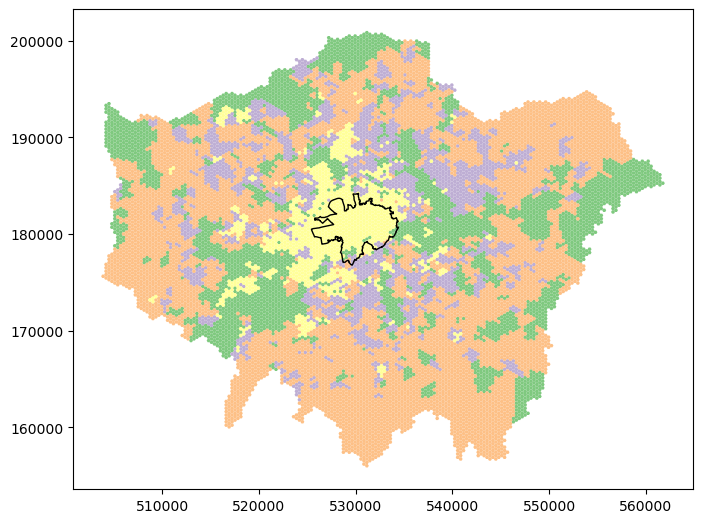

In [55]:
# Create a color map from 'Accent'
cmap = plt.get_cmap('Accent')
# Assuming the 'cluster' column holds the cluster labels
cluster_labels = list(range(1, 5))
# Create a dictionary to map each cluster label to a color from 'tab10'
color_mapping = {label: cmap(i) for i, label in enumerate(cluster_labels)}
# Plot the GeoDataFrame, setting the color for each cluster
fig, ax = plt.subplots(figsize=(8, 8))
for label, color in color_mapping.items():
    hex_cluster_res[hex_cluster_res['clst_hgi'] == label].plot(ax=ax, color=color)

# Plot CAZ, no fill color
caz.plot(ax=ax, edgecolor='black', facecolor='none')
# Show plot
plt.show()

# Output the results

In [56]:
hex_cluster_res

,Col_ID,Row_ID,Hex_ID,Centroid_X,Centroid_Y,area,geometry,clst_calliper,clst_space2vec,clst_hgi
0,1063,1211,10631211,503871.30860,175625.7975,106088.115,"POLYGON ((503669.236 175625.797, 503770.272 17...",2,1,3
1,1064,1210,10641210,504174.41745,175450.7975,106088.080,"POLYGON ((503972.345 175450.797, 504073.381 17...",2,1,3
2,1064,1212,10641212,504174.41745,175800.7975,106088.080,"POLYGON ((503972.345 175800.797, 504073.381 17...",1,3,3
3,1064,1214,10641214,504174.41745,176150.7975,106088.080,"POLYGON ((503972.345 176150.797, 504073.381 17...",1,1,3
4,1064,1216,10641216,504174.41745,176500.7975,106088.080,"POLYGON ((503972.345 176500.797, 504073.381 17...",2,1,3
...,...,...,...,...,...,...,...,...,...,...
15036,1253,1265,12531265,561461.99790,185075.7975,106088.115,"POLYGON ((561259.925 185075.797, 561360.962 18...",1,3,1
15037,1253,1267,12531267,561461.99790,185425.7975,106088.115,"POLYGON ((561259.925 185425.797, 561360.962 18...",1,1,1
15038,1253,1269,12531269,561461.99790,185775.7975,106088.115,"POLYGON ((561259.925 185775.797, 561360.962 18...",1,2,1
15039,1253,1271,12531271,561461.99790,186125.7975,106088.115,"POLYGON ((561259.925 186125.797, 561360.962 18...",1,1,1


In [57]:
hex_cluster_res.to_file("results/shp/hex_kmeans_cluster.shp")

/tmp/ipykernel_3441356/1657036189.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  hex_cluster_res.to_file("results/shp/hex_kmeans_cluster.shp")


# Plot all six cluster results

In [58]:
hex_clusters = gpd.read_file("results/shp/hex_kmeans_cluster.shp")
hex_clusters

,Col_ID,Row_ID,Hex_ID,Centroid_X,Centroid_Y,area,clst_calli,clst_space,clst_hgi,geometry
0,1063,1211,10631211,503871.30860,175625.7975,106088.115,2,1,3,"POLYGON ((503669.236 175625.797, 503770.272 17..."
1,1064,1210,10641210,504174.41745,175450.7975,106088.080,2,1,3,"POLYGON ((503972.345 175450.797, 504073.381 17..."
2,1064,1212,10641212,504174.41745,175800.7975,106088.080,1,3,3,"POLYGON ((503972.345 175800.797, 504073.381 17..."
3,1064,1214,10641214,504174.41745,176150.7975,106088.080,1,1,3,"POLYGON ((503972.345 176150.797, 504073.381 17..."
4,1064,1216,10641216,504174.41745,176500.7975,106088.080,2,1,3,"POLYGON ((503972.345 176500.797, 504073.381 17..."
...,...,...,...,...,...,...,...,...,...,...
15036,1253,1265,12531265,561461.99790,185075.7975,106088.115,1,3,1,"POLYGON ((561259.925 185075.797, 561360.962 18..."
15037,1253,1267,12531267,561461.99790,185425.7975,106088.115,1,1,1,"POLYGON ((561259.925 185425.797, 561360.962 18..."
15038,1253,1269,12531269,561461.99790,185775.7975,106088.115,1,2,1,"POLYGON ((561259.925 185775.797, 561360.962 18..."
15039,1253,1271,12531271,561461.99790,186125.7975,106088.115,1,1,1,"POLYGON ((561259.925 186125.797, 561360.962 18..."


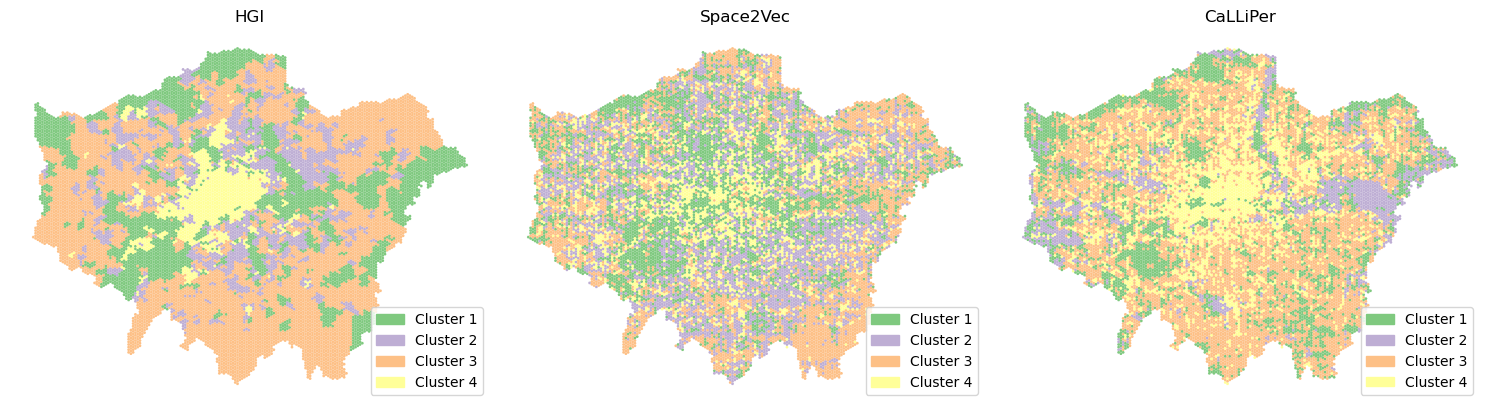

In [65]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Define the column names for the different methods
methods = ['clst_hgi', 'clst_space', 'clst_calli']
method_names = ['HGI', 'Space2Vec', 'CaLLiPer']

# Set up a colormap with 4 distinct colors using "Accent" for 4 clusters
cmap = mcolors.ListedColormap(plt.cm.Accent.colors[:4])

# Create subplots: 1 row and 3 columns
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Create a legend with markers instead of a colorbar
cluster_labels = [f'Cluster {i+1}' for i in range(4)]  # Assuming 4 clusters
legend_patches = [mpatches.Patch(color=cmap.colors[i], label=cluster_labels[i]) for i in range(4)]

# Loop through methods and axes to plot each method's clustering result
for i, method in enumerate(methods):
    # Plot GeoDataFrame by method column
    hex_clusters.plot(column=method, ax=axes[i], cmap=cmap, legend=False)

    method_name = method_names[i]
    
    # Set the title for each subplot
    axes[i].set_title(f"{method_name}")
    
    # Add legend with markers
    axes[i].legend(handles=legend_patches, loc='lower right')

    # Remove axis
    axes[i].axis('off')

plt.tight_layout()

# Save the plot
plt.savefig('results/plots/hex_clusters_all.png', dpi=300)

# Show the plot
plt.show()
